In [1]:
"""
Use trial results produced from ../scripts/03

Those results are all about two example GRBs: 
GRB180423A and GRB190415A

n_injs         = np.round(np.r_[0:9.1:0.2], 2)
n_trials       = 500
tws_in_second  = [10, 25, 50, 100, 250, 500]
"""

'\nUse trial results produced from ../scripts/03\n\nThose results are all about two example GRBs: \nGRB180423A and GRB190415A\n\nn_injs         = np.round(np.r_[0:9.1:0.2], 2)\nn_trials       = 500\ntws_in_second  = [10, 25, 50, 100, 250, 500]\n'

In [1]:
import os
import sys
print("Python version: ", end=' ')
print(sys.version)

import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import seaborn as sns
sns.set_theme(style="whitegrid")
############# comment out below two lines on clusters ##########
%matplotlib inline
# %matplotlib notebook

################################################################
from glob import glob
timer = cy.timing.Timer()
time = timer.time

###### Local Import ######
sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
LOCATION = paths.LOCATION
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *

Python version:  3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]

#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [2]:
print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
bins_logenergy = np.linspace(min_log_e, 4, 25+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.10', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
# on OSG
# ana_dir = "./"
ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=True)  # false to save memory if needed 



===== Setting up csky =====

Setting up Analysis for:
greco_v2.10
Setting up greco_v2.10...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [3]:
import argparse

######################### CONFIGURE ARGUEMENTS #############################
# p = argparse.ArgumentParser(description="Background Trials",
#                             formatter_class=argparse.RawTextHelpFormatter)
# p.add_argument("--grb_name", default="GRB180423A", type=str, help="Name of one GRB")
# p.add_argument("--batchNtrials", default=10, type=int, help="Number of trials in this batch")
# args = p.parse_args()
###########################################################################

### testing on jupyter ###
class args:
    # grb_name = "GRB180423A"    # real healpix example
    # grb_name = "GRB190415A"    # fake healpix example
    
    def __init__(self, 
                 grb_name="GRB180423A", 
                 tw_in_second=10, 
                 ncpu=4, 
                 n_injs=np.round(np.r_[0:9.1:0.2], 2)):
        self.grb_name = grb_name
        self.tw_in_second = tw_in_second
        self.ncpu = ncpu
        self.n_injs = n_injs
##########################

In [4]:
def get_tr(info):
    args = info
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
    try:
        healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
        # healpix can contain negative values: faults due to Fermi-GBM
        healpix = np.maximum(healpix,0)
        ########## healpix reduce (< instead of <=) ##########
        healpix[healpix < isf_healpix(healpix, q=0.99)] = 0
    except:
        raise Exception("Cannot load the healpix for grb: {}\n".format(args.grb_name))
    grb_row = df.loc[df['grb_name'] == args.grb_name]
    tw = args.tw_in_second/86400.
    tw_start = grb_row.t_center - 0.5*tw
    ra = grb_row.ra
    dec = grb_row.dec
    #### used for basic trial_runner
    conf = {
        'ana': ana,
        #### llh basics: csky.conf
        'space': 'prior', # ps/fitps/template/prior
        'time': 'transient', # utf/lc/transient
        'energy': 'customflux', # fit/customflux
        'flux': cy.hyp.PowerLawFlux(2),
        #### inj.py - prior has some duplications against space's prior
        'sig': 'transient', # ps/tw/lc/transient/template/prior
        'full_sky': True,
        'extended': True,
        'mp_cpus': args.ncpu,
        'cut_n_sigma': 3
    }
    cy.CONF.update(conf)
    src = cy.sources(
        ra=ra,
        dec=dec,
        deg=True,
        mjd=tw_start, 
        sigma_t=np.zeros_like(tw), 
        t_100=tw,  # in days
        prior=[hl.heal.HealHist(healpix)],
        name=args.grb_name
    )
    tr = cy.get_trial_runner(ana=ana, src=src)
    return tr

In [77]:
def get_sens_disc(info):
    args = info
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")
    try:
        healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
        # healpix can contain negative values: faults due to Fermi-GBM
        healpix = np.maximum(healpix,0)
        ########## healpix reduce (< instead of <=) ##########
        healpix[healpix < isf_healpix(healpix, q=0.99)] = 0
    except:
        raise Exception("Cannot load the healpix for grb: {}\n".format(args.grb_name))
    grb_row = df.loc[df['grb_name'] == args.grb_name]
    tw = args.tw_in_second/86400.
    tw_start = grb_row.t_center - 0.5*tw
    ra = grb_row.ra
    dec = grb_row.dec
    
    #### used for spatial_prior_trial_runner
    conf = {
        'ana': ana,
        #### llh basics: csky.conf
        'space': 'ps', # ps/fitps/template/prior
        'time': 'transient', # utf/lc/transient
        'energy': 'customflux', # fit/customflux
        'flux': cy.hyp.PowerLawFlux(2),
        #### inj.py - prior has some duplications against space's prior
        'sig': 'transient', # ps/tw/lc/transient/template/prior
        'full_sky': True,
        'extended': True,
        'mp_cpus': args.ncpu,
        'cut_n_sigma': 3
        }
    cy.CONF.update(conf)
    #### used for basic trial_runner
    # conf = {
    #     'ana': ana,
    #     #### llh basics: csky.conf
    #     'space': 'prior', # ps/fitps/template/prior
    #     'time': 'transient', # utf/lc/transient
    #     'energy': 'customflux', # fit/customflux
    #     'flux': cy.hyp.PowerLawFlux(2),
    #     #### inj.py - prior has some duplications against space's prior
    #     'sig': 'transient', # ps/tw/lc/transient/template/prior
    #     'full_sky': True,
    #     'extended': True,
    #     'mp_cpus': args.ncpu,
    #     'cut_n_sigma': 3
    # }
    # cy.CONF.update(conf)
    
    bg_files = glob(ANA_DIR+"/allsky_scan/with_prior_background/tw{}/{}*.npz".format(args.tw_in_second, args.grb_name))
#     bg = cy.dists.Chi2TSD(np.ravel([sparse.load_npz(bg_file).toarray() for bg_file in bg_files]))
    bg = cy.dists.Chi2TSD(np.ravel([sparse.load_npz(bg_file).toarray() for bg_file in bg_files])[:100000])
    print(bg)
    n_injs = args.n_injs
    sig = {}
    for n_inj in n_injs:
        sig_files = glob(ANA_DIR+"/prior_injection/tw{}/{}/{}*{}.npy".format(
            args.tw_in_second, 
            args.grb_name, 
            args.grb_name,
            n_inj))
        sig[n_inj] = cy.utils.Arrays(np.ravel([np.load(sig_file) for sig_file in sig_files]))
    trials = sig
    trials.update({0: bg.trials})
    
    src = cy.sources(
        ra=ra,
        dec=dec,
        deg=True,
        mjd=tw_start, 
        sigma_t=np.zeros_like(tw), 
        t_100=tw,  # in days
        prior=[hl.heal.HealHist(healpix)],
        name=args.grb_name
    )

    sptr = cy.get_spatial_prior_trial_runner(conf=cy.CONF
                                             ,src_tr=src
                                             ,llh_priors=[healpix]
                                             ,cut_n_sigma=5.) # src_tr is must for transient

    # tr = cy.get_trial_runner(ana=ana, src=src)
    
    sens = sptr.find_n_sig(ts=bg.median(), 
                           beta=0.9, 
                           max_batch_size=0, 
                           logging=True, 
                           trials=trials, n_bootstrap=1)
    # 3-sigma 
    disc = sptr.find_n_sig(ts=bg.isf_nsigma(3), 
                           beta=0.9, 
                           max_batch_size=0, 
                           logging=True, 
                           trials=trials, n_bootstrap=1)
    return sens, disc
    

In [78]:
from cycler import cycler
mpl_colors_orig = np.array (plt.matplotlib.rcParamsDefault['axes.prop_cycle'].by_key()['color'])
mpl_colors = mpl_colors_orig[[0, 3, 2, 1, 4, 5, 6, 7]]
plt.rc ('axes', prop_cycle=cycler ('color', mpl_colors))

# GBM-GRB: GRB180423A

In [79]:
ag = args(grb_name="GRB180423A",tw_in_second=250)
sens, disc =get_sens_disc(ag)


Chi2TSD(100000 trials, eta=0.176, ndof=1.000, median=0.000 (from fit 0.000))
Start time: 2021-10-29 23:27:09.816984
Using 4 cores.
* Generating batches of 50 trials...
n_trials | n_inj    0.00    0.20    0.40    0.60    0.80    1.00    1.20    1.40    1.60    1.80    2.00    2.20    2.40    2.60    2.80    3.00    3.20    3.40    3.60    3.80    4.00    4.20    4.40    4.60    4.80    5.00    5.20    5.40    5.60    5.80    6.00    6.20    6.40    6.60    6.80    7.00    7.20    7.40    7.60    7.80    8.00    8.20    8.40    8.60    8.80    9.00  |  n_sig(relative error)
500      |         17.6%   31.6%   39.0%   47.2%   54.4%   61.4%   66.6%   72.8%   76.4%   79.8%   82.4%   84.8%   87.4%   89.2%   91.4%   93.2%   94.0%   94.8%   95.8%   95.8%   96.0%   97.0%   97.2%   97.6%   98.0%   98.0%   98.0%   98.4%   98.6%   98.6%   98.6%   98.8%   99.2%   99.4%   99.6%   99.6%   99.6%   99.6%   99.8%   99.8%   99.8%   99.8%   99.8%   99.8%   99.8%  100.0%  |      2.724 (+/-  0.0%) [chi2.cdf]

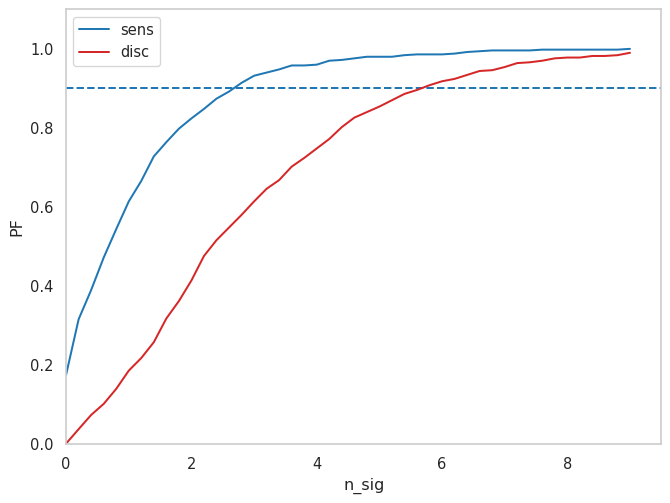

In [80]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)
sens_n_sig_PF = pd.DataFrame({'n_sig':sens['info']['n_sigs'], 'PF':sens['info']['spline'](sens['info']['n_sigs'])})
sns.lineplot(x="n_sig", y="PF",data=sens_n_sig_PF, markers=True, dashes=False, label="sens")
ax.axhline(0.9, linestyle='--')

disc_n_sig_PF = pd.DataFrame({'n_sig':disc['info']['n_sigs'], 'PF':disc['info']['spline'](disc['info']['n_sigs'])})
sns.lineplot(x="n_sig", y="PF",data=disc_n_sig_PF, markers=True, dashes=False, label="disc")
# ax.axhline(0.5, linestyle='--', c='tab:orange')

ax.set_xlim(0,9.5)
ax.set_ylim(0,1.1)
ax.grid()

In [81]:
sens['n_sig'], disc['n_sig']

(2.723525941897757, 5.648198733783358)

/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


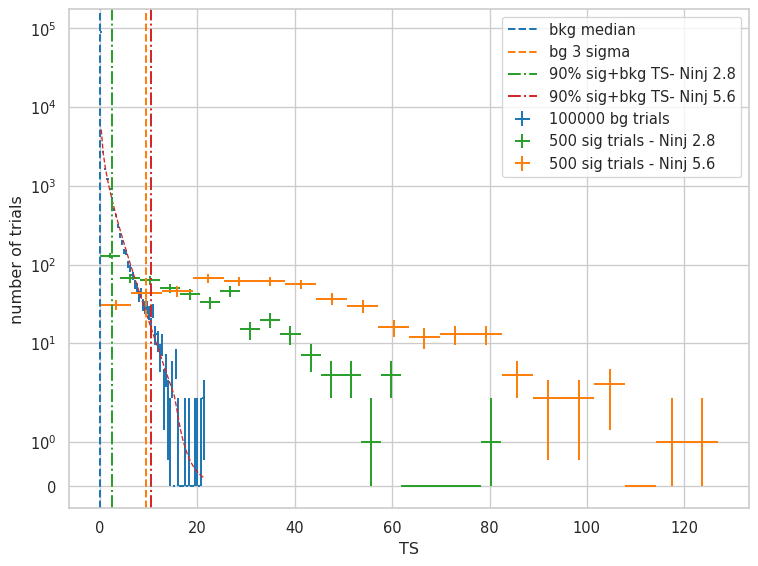

In [82]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)

# csky uses histlite all over the place for PDF management
# the background distribution fit integrates with histlite as well
bg = cy.dists.Chi2TSD(sens['tss'][0])
hbg = bg.get_hist(bins=50)
hl.plot1d(ax, hbg, crosses=True,
          label='{} bg trials'.format(bg.n_total))
ax.axvline(bg.median(), linestyle='--', label="bkg median", color='tab:blue')
x = hbg.centers[0]
norm = hbg.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--')
ax.axvline(x=bg.isf_nsigma(3), linestyle='--', label='bg 3 sigma', color='tab:orange')


sg = cy.dists.Chi2TSD(sens['tss'][2.8])
hsg = sg.get_hist(bins=20)
hl.plot1d(ax, hsg, crosses=True,
          label='{} sig trials - Ninj {}'.format(sg.n_total, 2.8))
ax.axvline(x=np.quantile(sg.values, 0.1), linestyle="-.",
            label="90% sig+bkg TS- Ninj {}".format(2.8), color='tab:green')


sg = cy.dists.Chi2TSD(disc['tss'][5.6])
hsg = sg.get_hist(bins=20)
hl.plot1d(ax, hsg, crosses=True,
          label='{} sig trials - Ninj {}'.format(sg.n_total, 5.6))
ax.axvline(x=np.quantile(sg.values, 0.1), linestyle="-.",
            label="90% sig+bkg TS- Ninj {}".format(5.6), color='tab:red')

ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.set_yscale('symlog')
ax.legend()
plt.tight_layout()

In [56]:
senss = []
discs = []
sens_fluxs = []
disc_fluxs = []
for tw in [10, 25, 50, 100, 250, 500]:
    ag = args(grb_name="GRB180423A",tw_in_second=tw)
    sens, disc =get_sens_disc(ag)
    senss.append(sens['n_sig'])
    discs.append(disc['n_sig'])
    tr = get_tr(ag)
    sens_fluxs.append(tr.to_E2dNdE(sens['n_sig'], E0=1, unit=1e1)) # GeV/cm2  @  1 GeV
    disc_fluxs.append(tr.to_E2dNdE(disc['n_sig'], E0=1, unit=1e1)) # GeV/cm2  @  1 GeV
                      

In [57]:
tw_sens_disc = pd.DataFrame({'tw':[10, 25, 50, 100, 250, 500], 
                             'sens': senss, 
                             'disc':discs, 
                             'sens_flux':sens_fluxs, 
                             'disc_flux':disc_fluxs})
tw_sens_disc

,tw,sens,disc,sens_flux,disc_flux
0,10,2.488178,1.183695,0.242497,0.115363
1,25,2.487298,1.296863,0.242412,0.126392
2,50,2.569094,1.419982,0.250383,0.138391
3,100,2.630759,1.528506,0.256393,0.148968
4,250,2.897175,1.864070,0.282358,0.181672
5,500,3.324511,2.327610,0.324006,0.226849


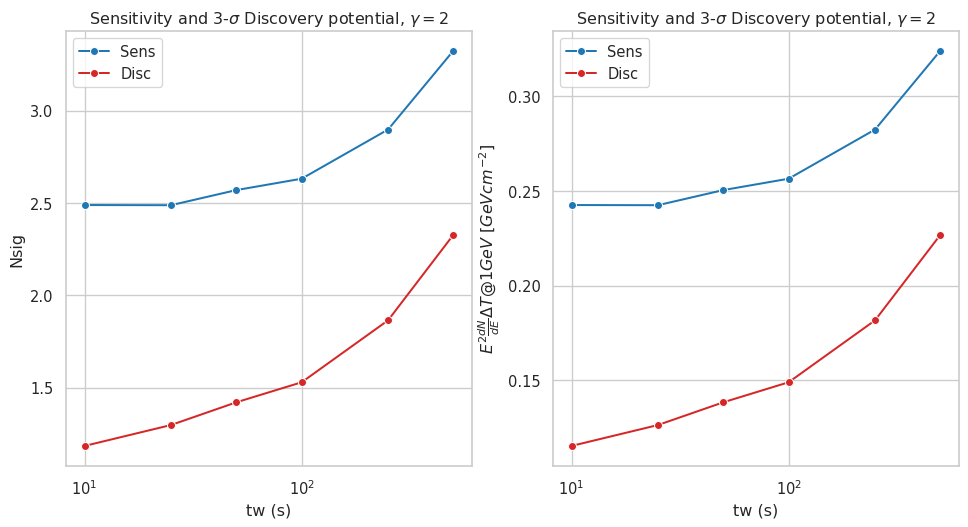

In [64]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi=96)
# dts = [10, 25, 50, 100, 250, 500]
# plt.plot(dts ,senss,'-+',color='C0', label = 'Sensitivity (90% C.L.)')
# plt.plot(dts ,discs,'-+',color='C1',label = r'$3-\sigma$ Discovery Potential (50\% C.L.)')

sns.lineplot(data=tw_sens_disc, x='tw', y='sens', marker='o', label='Sens', ax=ax[0])
sns.lineplot(data=tw_sens_disc, x='tw', y='disc', marker='o', label='Disc', ax=ax[0])

sns.lineplot(data=tw_sens_disc, x='tw', y='sens_flux', marker='o', label='Sens', ax=ax[1])
sns.lineplot(data=tw_sens_disc, x='tw', y='disc_flux', marker='o', label='Disc', ax=ax[1])

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("tw (s)")
ax[1].set_xlabel("tw (s)")
ax[0].set_ylabel("Nsig")
ax[1].set_ylabel(r'$E^2\frac{dN}{dE}\Delta T @ 1 GeV$ [$GeV cm^{-2}$]')
ax[0].set_title(r'Sensitivity and 3-$\sigma$ Discovery potential, $\gamma=2$')
ax[1].set_title(r'Sensitivity and 3-$\sigma$ Discovery potential, $\gamma=2$')

# plt.text(1e4, 3, 'IceCube Preliminary', color='r', fontsize=18)
plt.show()

# nonGBM-GRB: GRB190415A

In [65]:
ag = args(grb_name="GRB190415A",tw_in_second=250)
sens, disc =get_sens_disc(ag)


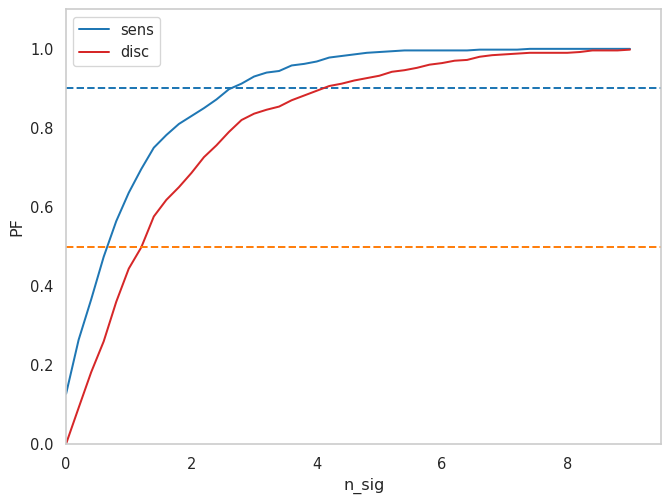

In [66]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)
sens_n_sig_PF = pd.DataFrame({'n_sig':sens['info']['n_sigs'], 'PF':sens['info']['spline'](sens['info']['n_sigs'])})
sns.lineplot(x="n_sig", y="PF",data=sens_n_sig_PF, markers=True, dashes=False, label="sens")
ax.axhline(0.9, linestyle='--')

disc_n_sig_PF = pd.DataFrame({'n_sig':disc['info']['n_sigs'], 'PF':disc['info']['spline'](disc['info']['n_sigs'])})
sns.lineplot(x="n_sig", y="PF",data=disc_n_sig_PF, markers=True, dashes=False, label="disc")
ax.axhline(0.5, linestyle='--', c='tab:orange')

ax.set_xlim(0,9.5)
ax.set_ylim(0,1.1)
ax.grid()

In [67]:
sens['n_sig'], disc['n_sig']

(2.623400171167356, 1.206119315360424)

/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/storage/home/hhive1/cchen641/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


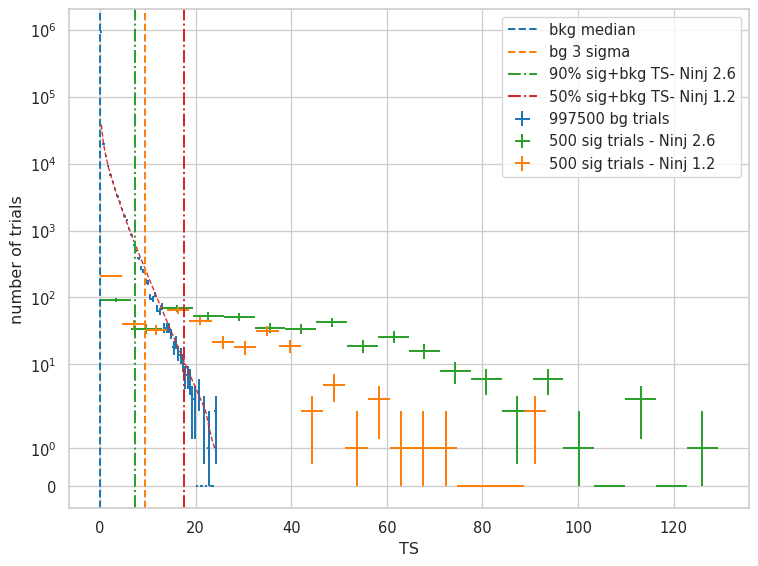

In [68]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)

# csky uses histlite all over the place for PDF management
# the background distribution fit integrates with histlite as well
bg = cy.dists.Chi2TSD(sens['tss'][0])
hbg = bg.get_hist(bins=50)
hl.plot1d(ax, hbg, crosses=True,
          label='{} bg trials'.format(bg.n_total))
ax.axvline(bg.median(), linestyle='--', label="bkg median", color='tab:blue')
x = hbg.centers[0]
norm = hbg.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--')
ax.axvline(x=bg.isf_nsigma(3), linestyle='--', label='bg 3 sigma', color='tab:orange')

sg = cy.dists.Chi2TSD(sens['tss'][2.6])
hsg = sg.get_hist(bins=20)
hl.plot1d(ax, hsg, crosses=True,
          label='{} sig trials - Ninj {}'.format(sg.n_total, 2.6))
ax.axvline(x=np.quantile(sg.values, 0.1), linestyle="-.",
            label="90% sig+bkg TS- Ninj {}".format(2.6), color='tab:green')


sg = cy.dists.Chi2TSD(sens['tss'][1.2])
hsg = sg.get_hist(bins=20)
hl.plot1d(ax, hsg, crosses=True,
          label='{} sig trials - Ninj {}'.format(sg.n_total, 1.2))
ax.axvline(x=np.quantile(sg.values, 0.5), linestyle="-.",
            label="50% sig+bkg TS- Ninj {}".format(1.2), color='tab:red')

ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.set_yscale('symlog')
ax.legend()
plt.tight_layout()

In [69]:
senss = []
discs = []
sens_fluxs = []
disc_fluxs = []
for tw in [10, 25, 50, 100, 250, 500]:
    ag = args(grb_name="GRB190415A",tw_in_second=tw)
    sens, disc =get_sens_disc(ag)
    senss.append(sens['n_sig'])
    discs.append(disc['n_sig'])
    tr = get_tr(ag)
    sens_fluxs.append(tr.to_E2dNdE(sens['n_sig'], E0=1, unit=1e1)) # GeV/cm2  @  1 GeV
    disc_fluxs.append(tr.to_E2dNdE(disc['n_sig'], E0=1, unit=1e1)) # GeV/cm2  @  1 GeV
                      

In [70]:
tw_sens_disc = pd.DataFrame({'tw':[10, 25, 50, 100, 250, 500], 
                             'sens': senss, 
                             'disc':discs, 
                             'sens_flux':sens_fluxs, 
                             'disc_flux':disc_fluxs})
tw_sens_disc

,tw,sens,disc,sens_flux,disc_flux
0,10,2.562864,0.866560,0.525069,0.177537
1,25,2.542314,0.912639,0.520859,0.186978
2,50,2.559923,0.952384,0.524466,0.195121
3,100,2.623510,1.068765,0.537494,0.218964
4,250,2.623400,1.206119,0.537471,0.247105
5,500,2.660018,1.258503,0.544973,0.257837


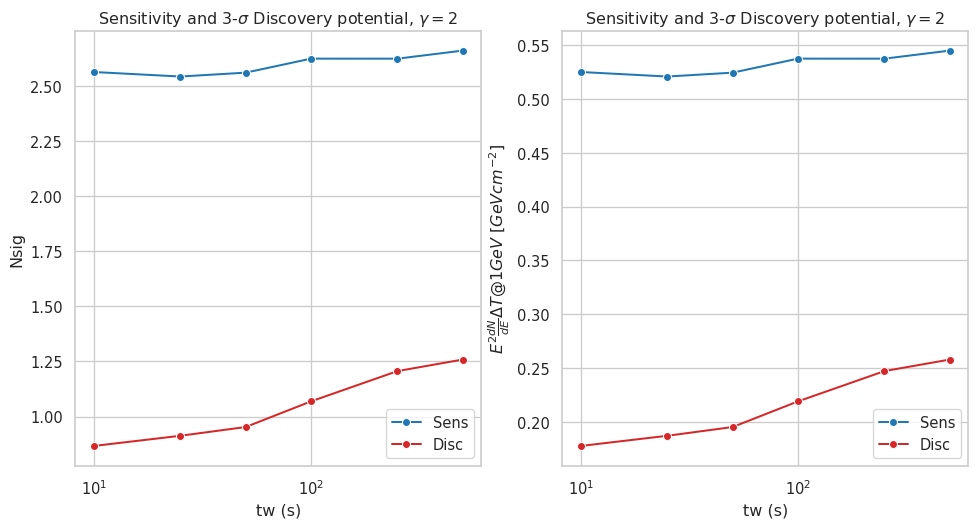

In [71]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi=96)
# dts = [10, 25, 50, 100, 250, 500]
# plt.plot(dts ,senss,'-+',color='C0', label = 'Sensitivity (90% C.L.)')
# plt.plot(dts ,discs,'-+',color='C1',label = r'$3-\sigma$ Discovery Potential (50\% C.L.)')

sns.lineplot(data=tw_sens_disc, x='tw', y='sens', marker='o', label='Sens', ax=ax[0])
sns.lineplot(data=tw_sens_disc, x='tw', y='disc', marker='o', label='Disc', ax=ax[0])

sns.lineplot(data=tw_sens_disc, x='tw', y='sens_flux', marker='o', label='Sens', ax=ax[1])
sns.lineplot(data=tw_sens_disc, x='tw', y='disc_flux', marker='o', label='Disc', ax=ax[1])

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("tw (s)")
ax[1].set_xlabel("tw (s)")
ax[0].set_ylabel("Nsig")
ax[1].set_ylabel(r'$E^2\frac{dN}{dE}\Delta T @ 1 GeV$ [$GeV cm^{-2}$]')
ax[0].set_title(r'Sensitivity and 3-$\sigma$ Discovery potential, $\gamma=2$')
ax[1].set_title(r'Sensitivity and 3-$\sigma$ Discovery potential, $\gamma=2$')

# plt.text(1e4, 3, 'IceCube Preliminary', color='r', fontsize=18)
plt.show()

# Two GRB info

In [72]:
df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHeaplix.pkl")


In [79]:
two_grbs = df.loc[(df['grb_name'] == "GRB180423A") | (df['grb_name'] == "GRB190415A")]
two_grbs['t_100_in_second'] = two_grbs['t100'] * 86400


/storage/home/hhive1/cchen641/.conda/envs/icecube_py3/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [87]:
two_grbs[['grb_name', 'ra', 'dec', 'mjd_start', 't_100_in_second', 't100', 't90',
       'gbm', 'source_uncertainty']]

,grb_name,ra,dec,mjd_start,t_100_in_second,t100,t90,gbm,source_uncertainty
50,GRB190415A,28.054167,20.266667,58588.173449,57.221,0.000662,0.000607,0,4.100000
342,GRB180423A,208.680000,9.840000,58231.032586,54.784,0.000634,0.000634,1,4.794662


In [83]:
two_grbs.columns

Index(['grb_name', 'grb_name_GBM', 'ra', 'dec', 'mjd_start', 't100', 't90',
       'gbm', 'source_uncertainty', 'redshift', 't_center', 'hasHealpix',
       't_100_in_second'],
      dtype='object')